In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date
from scipy.stats import permutation_test
pd.options.mode.chained_assignment = None
sns.set_style('dark')

Sentiment predictions by page number and publication company.

In [2]:
# The publisher page and sentiment information are split up because I am using two ProQuest accounts (double the GPU power).
us_apr_feb2021_publisher_page_df = pd.read_csv('csv/us_apr-feb2021_publisher_page_df.csv', index_col=[0])
pre_page_df = us_apr_feb2021_publisher_page_df[['page', 'total_page', 'page_prediction']]
pre_publisher_df = us_apr_feb2021_publisher_page_df[['publisher_name', 'total_published', 'publisher_prediction']]

publisher_page_us_mar_apr2022 = pd.read_csv('csv/publisher_page_us-mar-apr2022.csv', index_col=[0])
post_page_df = publisher_page_us_mar_apr2022[['page', 'total_page', 'page_prediction']]
post_publisher_df = publisher_page_us_mar_apr2022[['publisher_name', 'total_published', 'publisher_prediction']]

publisher_df = pd.merge(pre_publisher_df, post_publisher_df, on='publisher_name', how='inner')
page_df = pd.merge(pre_page_df, post_page_df, on='page', how='inner')

page_df['sentiment'] = page_df.eval("(page_prediction_x + page_prediction_y) / (total_page_x + total_page_y)")
page_df = page_df[['page', 'sentiment']]
publisher_df['sentiment'] = publisher_df.eval('(publisher_prediction_x + publisher_prediction_y) / (total_published_y + total_published_x)')
publisher_df = publisher_df[['publisher_name', 'sentiment']]

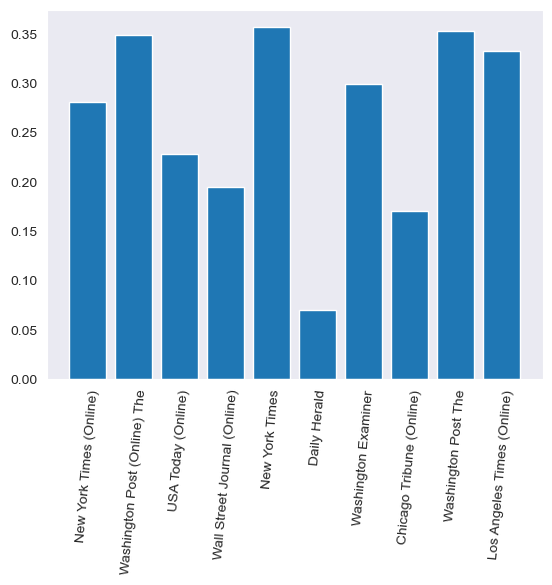

In [3]:
plot_pub = publisher_df.head(10)
# plt.figure(figsize=(10,10))
plt.bar(x=plot_pub.publisher_name, height=plot_pub.sentiment*-1)
plt.xticks(rotation=85);

In [5]:
# Covid Health Data from OurWorldinData
health_data_df = pd.read_csv('csv/us_cleaned_health_data.csv', parse_dates=['date'])
us_2021_df = pd.read_csv('csv/us_apr-feb2021.csv', index_col=[0], parse_dates=['date'])
us_2022_df = pd.read_csv('csv/us-mar-apr2022.csv', index_col=[0], parse_dates=['date'])
df = pd.concat([us_2021_df,us_2022_df], axis=0)

health_data_df = health_data_df[(health_data_df.date >= df.date.min()) & (health_data_df.date <= df.date.max())]
health_data_df = health_data_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 
                                'new_vaccinations_smoothed','positive_rate', 'new_cases', 'date']]
df = df.merge(health_data_df, on='date')
df = df.set_index('date', drop=False)
# Smoothing trends to help with the inherent noise of sentiment calculations.
df['smoothed_prediction'] = df.prediction.rolling(window=5, center=True, win_type='gaussian').mean(std=2)
df['smoothed_articles_per_day'] = df.articles_per_day.rolling(window=4, center=True, win_type='gaussian').mean(std=1)

Compare df

In [63]:
t_df = pd.read_parquet('parquet/us_full_covid.parquet')
t_df['prediction'] = np.where(t_df['prediction'] == 0, -1, 1)
t_df = t_df.groupby(['date','article_id']).agg({'publisher': 'first', 'page_num':'first', 'prediction':'mean'})

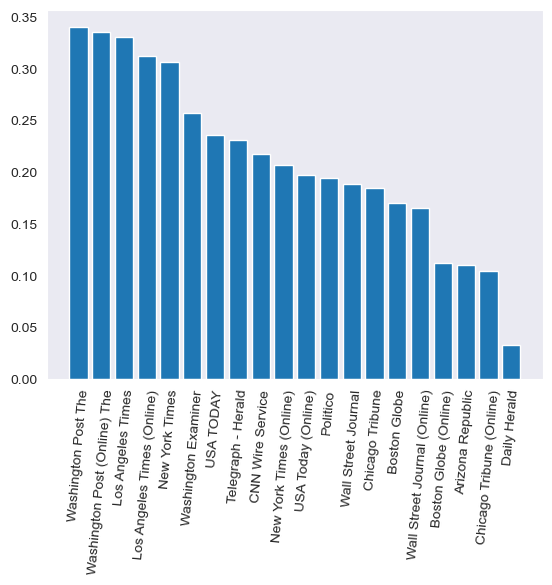

In [92]:
top_publishers = t_df.publisher.value_counts()[:20].index
cc = t_df.groupby('publisher')['prediction'].mean()
cc = cc[cc.index.isin(top_publishers)]
cc = cc.sort_values()
plt.bar(x=cc.index, height=cc * -1)
plt.xticks(rotation=85);

In [28]:
t_df = t_df.reset_index(level=1)

Bootstrapping sample median to get error estimates. The estimate of the variance is $$\widehat{Var}_B(M_n) = \frac{1}{B-1}$$

In [5]:
bootstrapped_medians = []
n_sims = 10000
for sim in range(n_sims):
    sample = df.sample(n=df.shape[0], replace=True)['prediction'].mean()
    bootstrapped_medians.append(sample)
boot_var_sum = 0
avg_boot_median = np.mean(bootstrapped_medians)
for sample in bootstrapped_medians:
    boot_var_sum += (avg_boot_median - sample)**2
boot_var = boot_var_sum / (n_sims-1)
print(avg_boot_median)
print(round(boot_var,4))

-0.18370939626044877
0.0


In [6]:
print(f'The average sentiment score for articles is {np.around(df.prediction.mean(),3)}')
# print(f'The average sentiment score for titles is {np.around(us_titles.title_prediction.mean(),3)}')
# print(f'The average sentiment score for non-covid articles is {np.around(reg_df.prediction.mean(),3)}')

The average sentiment score for articles is -0.184


In [7]:
pre_delta = df[(df.date >= '2020-12-15') & (df.date < '2021-06-01')]
predictor_list = ['new_cases', 'new_cases_smoothed', 'positive_rate','weekly_hosp_admissions', 'new_vaccinations_smoothed', 'new_deaths_smoothed']
predictor_list_noVax = ['new_cases', 'new_cases_smoothed','positive_rate' ,'weekly_hosp_admissions', 'new_deaths_smoothed']

<AxesSubplot:>

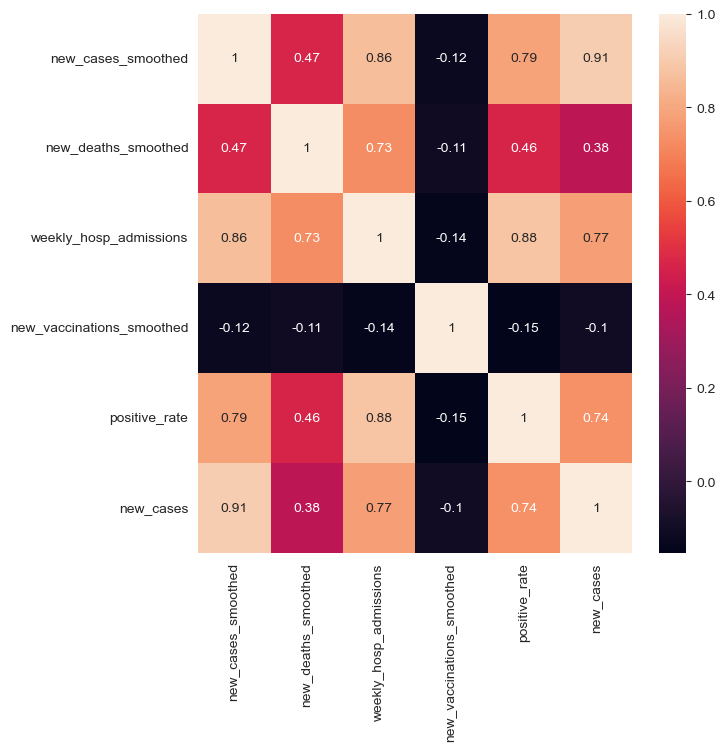

In [8]:
plt.figure(figsize=(7,7))
sns.heatmap(health_data_df.corr(), annot=True)

### Permutation Testing the Correlations

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.
<hr />

**ADF test** is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [26]:
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

# test_df = df.dropna(axis=0, subset=['smoothed_prediction', 'positive_rate'])
# test_df.smoothed_prediction.isna().sum()
# adfuller(test_df['smoothed_prediction'])

In [23]:
# Reject Ho means that positive Rate influences the sentiment  
grangercausalitytests(test_df[['positive_rate', 'smoothed_prediction']], maxlag=6)
# Cross Correlation:
correlation_c = np.correlate(test_df.positive_rate, test_df.smoothed_prediction, 'full')
dfc = pre_delta.diff(5).dropna()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=66.2317 , p=0.0000  , df_denom=743, df_num=1
ssr based chi2 test:   chi2=66.4991 , p=0.0000  , df=1
likelihood ratio test: chi2=63.7003 , p=0.0000  , df=1
parameter F test:         F=66.2317 , p=0.0000  , df_denom=743, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5379  , p=0.0797  , df_denom=740, df_num=2
ssr based chi2 test:   chi2=5.1100  , p=0.0777  , df=2
likelihood ratio test: chi2=5.0926  , p=0.0784  , df=2
parameter F test:         F=2.5379  , p=0.0797  , df_denom=740, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5219  , p=0.2075  , df_denom=737, df_num=3
ssr based chi2 test:   chi2=4.6092  , p=0.2028  , df=3
likelihood ratio test: chi2=4.5950  , p=0.2040  , df=3
parameter F test:         F=1.5219  , p=0.2075  , df_denom=737, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5799  , p=0.1778  

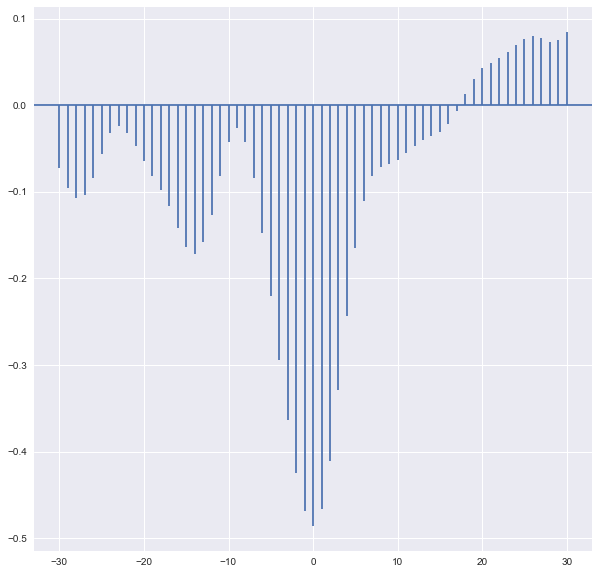

In [ ]:
plt.xcorr(dfc.positive_rate, dfc.smoothed_prediction, usevlines=1, maxlags=30);

In [1]:
# g_label = stats.pearsonr(df_corr.positive_rate, df_corr.smoothed_prediction)
# sns.regplot(x='new_cases_smoothed', y='smoothed_prediction', data=df_corr, scatter_kws={'alpha':0.50}, 
#             line_kws={'color': 'k', 'label':f'Pearson Correlation = {round(g_label[0],3)}'})
# plt.legend()

## Plotting the data

Text(0.5, 0, '')

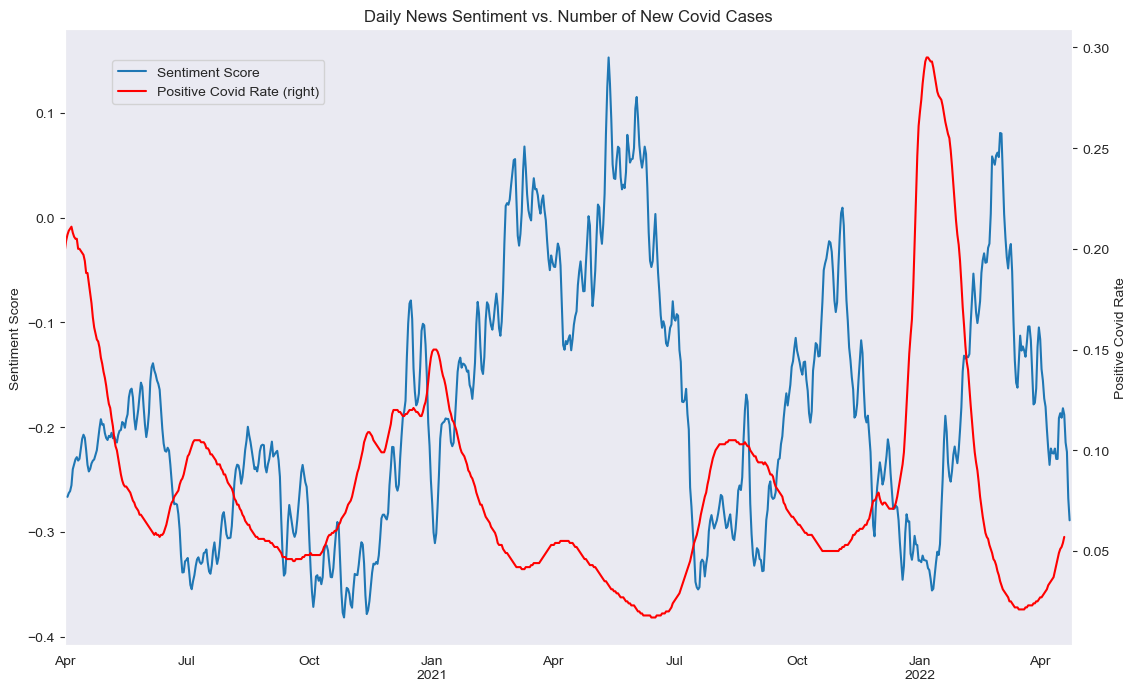

In [29]:
ax = df.plot(y="smoothed_prediction", legend=False, figsize=(13,8), label='Sentiment Score')
ax2 = df.plot(y="positive_rate", secondary_y=True,ax=ax, legend=False, color="r", label='Positive Covid Rate')

ax.figure.legend(bbox_to_anchor=(0.33, 0.85), frameon=True)
plt.title('Daily News Sentiment vs. Number of New Covid Cases')
ax.set_ylabel('Sentiment Score')
ax2.set_ylabel('Positive Covid Rate')
ax.set_xlabel('')
# plt.savefig('figures/entire_timeline_comparison.png', dpi=500)

**Daily articles Published**

Text(0.5, 0, '')

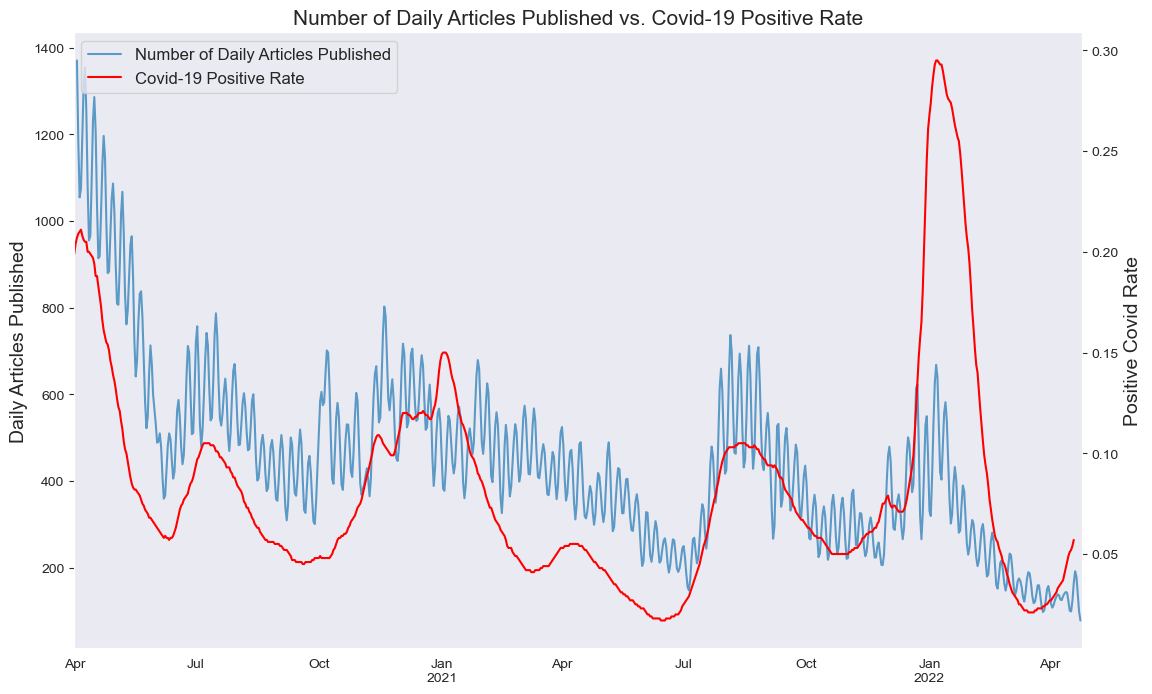

In [34]:
ax = df.plot(y="smoothed_articles_per_day", legend=False, figsize=(13,8), label='Number of Daily Articles Published', alpha=0.7, style='-')
ax2 = ax.twinx()
df.plot(y="positive_rate", ax=ax2, legend=False, color="r", label = 'Covid-19 Positive Rate')


ax.figure.legend(bbox_to_anchor=(0.38, 0.88), fontsize=12)
plt.title('Number of Daily Articles Published vs. Covid-19 Positive Rate', fontsize=15)
ax.set_ylabel('Daily Articles Published', fontsize=14)
ax2.set_ylabel('Positive Covid Rate', fontsize=14)
ax.set_xlabel('', fontsize=14)

# plt.savefig('figures/num_articles_published.png', dpi=500)

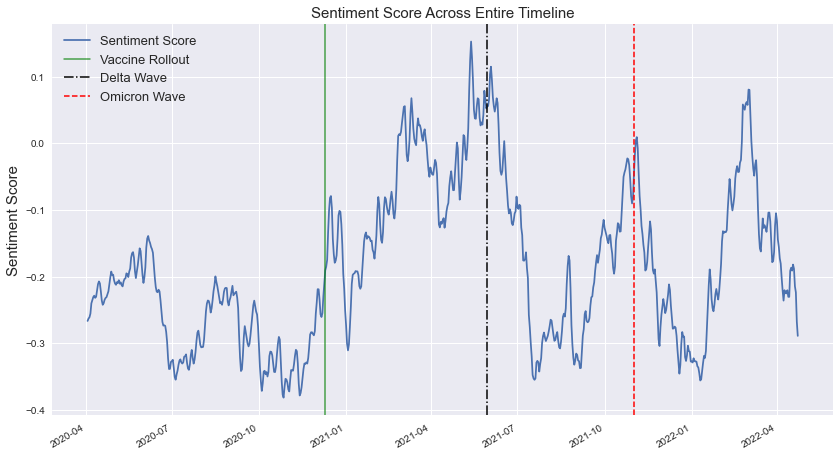

In [129]:
fig = plt.figure(figsize=(14,8))
sns.lineplot(data=df, x='date', y='smoothed_prediction', label='Sentiment Score')
fig.autofmt_xdate()
plt.xlabel('')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Across Entire Timeline')

plt.axvline(x=pd.to_datetime('2020-12-10'), color='g', linestyle='-',linewidth=1.5, label='Vaccine Rollout', alpha=0.7)
plt.axvline(x=pd.to_datetime('2021-05-30'), color='k', linestyle='-.',linewidth=1.5, label='Delta Wave')
plt.axvline(x=pd.to_datetime('2021-11-01'), color='r', linestyle='--',linewidth=1.5, label='Omicron Wave')

plt.legend(loc='upper left', fontsize=13, ncol=1,)
plt.savefig('figures/us_sentiment_3hlines.png', dpi=500)

In [ ]:
# plt.figure(figsize=(14,8))
# sns.lineplot(data=df, x='date', y='avg_predict', label='sentiment score')
# plt.ylabel('Sentiment Score',fontsize=15)
# plt.xlabel('Date', fontsize=15)
# plt.title('Sentiment Score Across Entire Timeline',fontsize=15)
# plt.axvline(x=pd.to_datetime('2021-06-01'), color='k', linestyle='-.',linewidth=1.5, label='Delta wave')
# plt.axvline(x=pd.to_datetime('2021-11-01'), color='r', linestyle='--',linewidth=1.5, label='Omicron wave')
# plt.axvline(x=pd.to_datetime('2021-01-10'), color='g', linestyle=':',linewidth=3, label='Vaccine rollout')
# plt.axhline(y=0, color='k', linestyle='--', linewidth=0.75)
# plt.legend(loc='upper left')
# plt.savefig('figures/sentiment_entire_timeline_3hlines.png')

In [132]:
# fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# sns.regplot(x=pre_delta.positive_rate, y=pre_delta.smoothed_prediction, ax=axs[0], label=f"correlation = {pre_delta_df.loc['positive_rate']['Pearson Correlation']}");
# axs[0].set_title('(January-June) Sentiment Score vs. Covid Positivity Rate');
# axs[0].set_ylabel('predicted sentiment score');
# axs[0].legend()

# sns.regplot(x=pre_delta.new_vaccinations_smoothed, y=pre_delta.smoothed_prediction, ax=axs[1], order=2, 
#                             label=f"correlation = {pre_delta_df.loc['new_vaccinations_smoothed'].max()}");
# axs[1].set_title('(January-June) Sentiment Score vs. New Vaccinations Administered');
# axs[1].set_ylabel('predicted sentiment score');
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.4, hspace=None)
# axs[1].legend()
# plt.savefig('figures/pre-delt_corr_vaccines & pos_rate.png')

## Isolating for specific correlation timelines

In [ ]:
overall_mean = df.prediction.mean()
print(f'average score across the entire timeline: {round(overall_mean,3)}')

def percent_change(avg):
    if avg > overall_mean:
        return np.around(((overall_mean - avg)/ overall_mean) * 100, 1)
    else:
        return np.around(((avg - overall_mean) / overall_mean) * -100, 1)

average_sentiment = []
percent_change_avg = []

average score across the entire timeline: -0.184


**Rereading the data in to reset the changes made from before**

In [ ]:
# us_df = pd.read_csv('csv/us_cleaned_health_data.csv') # Health Data
# pre_df = pd.read_csv('csv/NS_sep-dec2020.csv')
# df = pd.read_csv('csv/NS_jan-dec2021.csv')
# post_df = pd.read_csv('csv/NS_jan2022-mar2022.csv')
# df = pd.concat((pre_df, df, post_df),axis=0)
# df.drop('Unnamed: 0', axis=1, inplace=True)

# reg_df = pd.read_csv('csv/NS_regular_jan-dec2021.csv')
# daily_articles = pd.read_csv('csv/num_daily_articles.csv')
# us_titles = pd.read_csv('csv/NS_titles_jan-dec2021.csv')

# can_df = pd.read_csv('csv/NS_canada.csv')
# aus_df = pd.read_csv('csv/NS_australia_jan-dec2021.csv')

# df.date = pd.to_datetime(df.date)
# reg_df.date = pd.to_datetime(reg_df.date)
# us_df.date = pd.to_datetime(us_df.date)
# daily_articles.date = pd.to_datetime(daily_articles.date)
# us_titles.date = pd.to_datetime(us_titles.date)

# us_df = us_df[(us_df.date >= df.date.min()) & (us_df.date <= df.date.max())]
# us_df = us_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'new_vaccinations_smoothed', 
#                 'positive_rate', 'new_cases', 'date']]

# reg_df = reg_df.merge(us_df,on='date')
# df = df.merge(us_df, on='date')
# daily_articles = daily_articles.merge(df, on='date')

# df['avg_predict'] = df.prediction.rolling(window=4, center=True).mean()
# reg_df['avg_predict'] = reg_df.prediction.rolling(window=4, center=True).mean()

# df_corr = df.dropna(axis=0, subset='avg_predict')
# reg_df.dropna(axis=0, subset='avg_predict', inplace=True)

# daily_articles.rename({'article_id': 'num_articles'},axis=1, inplace=True)
# df = pd.concat((df, daily_articles.num_articles), axis=1)

In [ ]:
health_data_df = pd.read_csv('csv/us_cleaned_health_data.csv') # Health Data
pre_df = pd.read_csv('csv/us_apr-feb2021.csv', index_col=[0])
post_df = pd.read_csv('csv/us-mar-apr2022.csv', index_col=[0])
df = pd.concat((pre_df,post_df),axis=0)

# reg_df = pd.read_csv('csv/NS_regular_jan-dec2021.csv')
# daily_articles = pd.read_csv('csv/num_daily_articles.csv')
# us_titles = pd.read_csv('csv/NS_titles_jan-dec2021.csv').rename(columns={'prediction': 'title_prediction'})
# can_df = pd.read_csv('csv/NS_canada.csv',index_col=[0])
# aus_df = pd.read_csv('csv/NS_australia_jan-dec2021.csv', index_col=[0])

# reg_df.date = pd.to_datetime(reg_df.date)
df.date = pd.to_datetime(df.date)
health_data_df.date = pd.to_datetime(health_data_df.date)
# daily_articles.date = pd.to_datetime(daily_articles.date)
# us_titles.date = pd.to_datetime(us_titles.date)

health_data_df = health_data_df[(health_data_df.date >= df.date.min()) & (health_data_df.date <= df.date.max())]
health_data_df = health_data_df[['new_cases_smoothed', 'new_deaths_smoothed', 'weekly_hosp_admissions', 'new_vaccinations_smoothed', 
                'positive_rate', 'new_cases', 'date']]

# reg_df = reg_df.merge(health_data_df,on='date')
df = df.merge(health_data_df, on='date')

df['smoothed_prediction'] = df.prediction.rolling(window=8, center=True, win_type='gaussian').mean(std=3)
# df['smoothed_prediction'] = df.prediction.rolling(window=10, center=True, win_type='gaussian').sum(std=5)
# reg_df['avg_predict'] = reg_df.prediction.rolling(window=4, center=True).mean()
# us_titles['title_prediction'] = us_titles['title_prediction'].rolling(window=4,center=True).mean()
df_corr = df.dropna(axis=0, subset='smoothed_prediction')
# reg_df.dropna(axis=0, subset='avg_predict', inplace=True)

In [ ]:
non_na_preds = df.drop('new_vaccinations_smoothed',axis=1).columns[4:]
non_na_preds

Index(['new_deaths_smoothed', 'weekly_hosp_admissions', 'positive_rate',
       'new_cases', 'smoothed_prediction'],
      dtype='object')

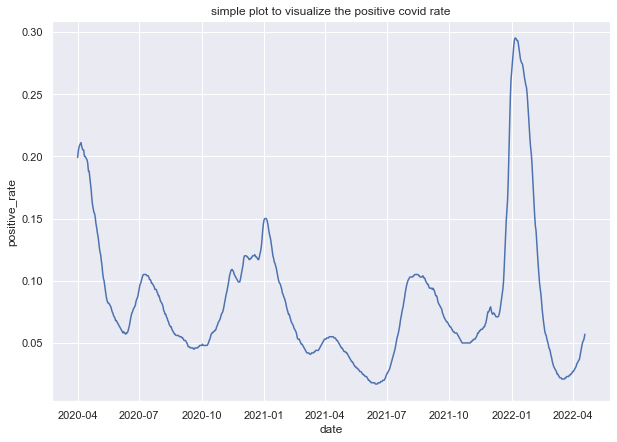

In [ ]:
plt.figure(figsize=(10,7))
sns.lineplot(data=df, x='date', y='positive_rate')
plt.title('simple plot to visualize the positive covid rate');

In [ ]:
# peak = '2021-09-01'
# sharp_decrease_df = df[(df.date <= peak)& (df.date >= '2021-07-01')]

# plt.figure(figsize=(10,7))
# sns.lineplot(data=sharp_decrease_df, x='date', y='positive_rate')
# # plt.title('(4) Sharp Decrease in Covid Cases (After Omicron)')
# plt.ylabel('Positive Rate')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig('figures/(4) Sharp Decrease in Covid Cases (After Omicron).png');

# sd_avg = sharp_decrease_df.prediction.mean()
# print(f'The average sentiment score during the sharp decrease  in cases: {round(sd_avg,3)}')
# print(f'percent change from the average: {percent_change(sd_avg)}%')

# timeline_sharp_dec = daily_articles[(daily_articles.date <= peak) & (daily_articles.date >= '2021-07-01')]

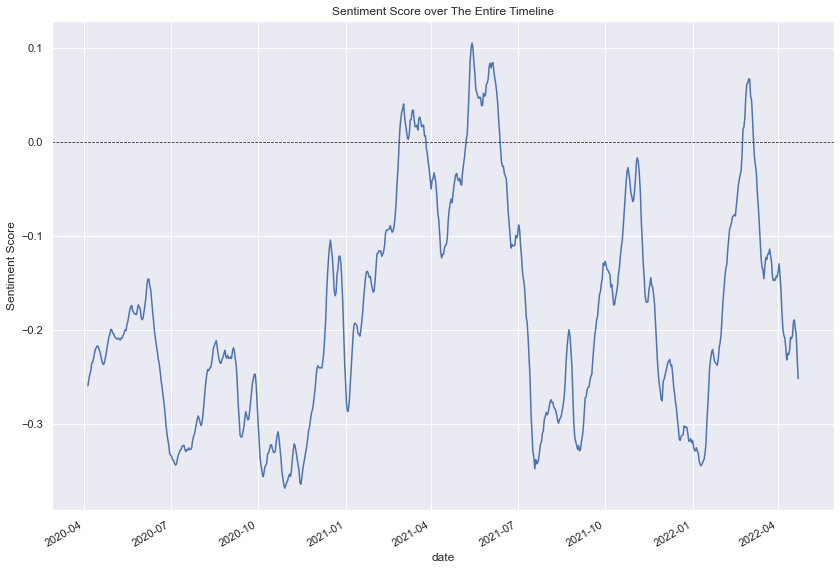

In [ ]:
fig = plt.figure(figsize=(14,10))
sns.lineplot(data=df, x='date', y='smoothed_prediction')
fig.autofmt_xdate()
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.75)
plt.title('Sentiment Score over The Entire Timeline')
plt.ylabel('Sentiment Score');

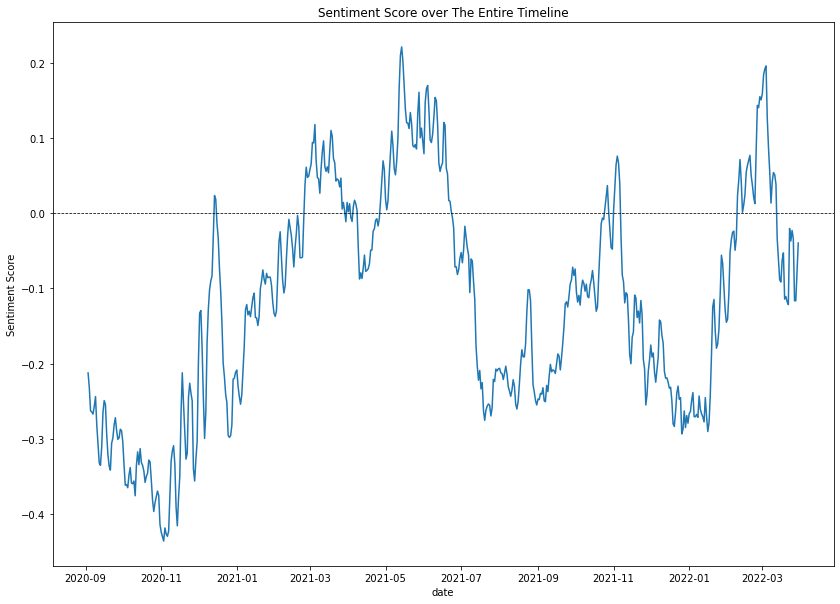

In [ ]:
plt.figure(figsize=(14,10))
sns.lineplot(data=df, x='date', y='avg_predict')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.75)
plt.title('Sentiment Score over The Entire Timeline')
plt.ylabel('Sentiment Score');

In [ ]:
max_case = df[df.date < '2022-03-01'].positive_rate.argmax()
min_case = df[df.date < '2021-03-31'].positive_rate.argmin() # Finds the index of the peak or minimum.
df.iloc[max_case]

date                         2022-01-06 00:00:00
prediction                             -0.373418
articles_per_day                           638.0
new_cases_smoothed                    620422.143
new_deaths_smoothed                       1410.0
weekly_hosp_admissions                  127763.0
new_vaccinations_smoothed               956614.0
positive_rate                              0.295
new_cases                               835016.0
smoothed_prediction                     -0.32902
Name: 645, dtype: object

**Slow Decline in Cases**

The average sentiment score during the long decrease in cases: -0.12
percent change from the average: 34.7%


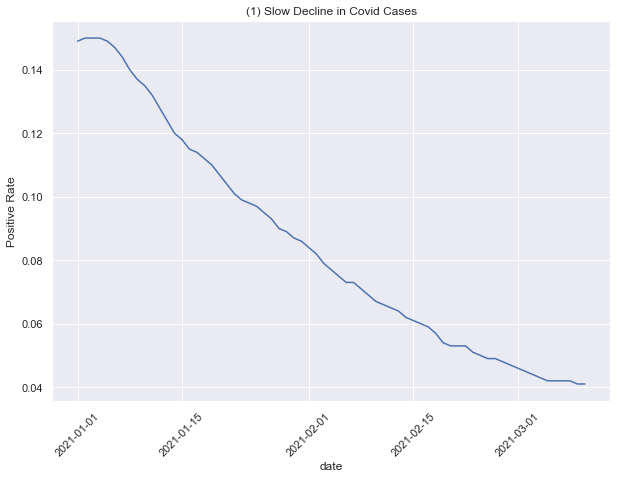

In [ ]:
peak_slow_dec = pd.to_datetime('2021-01-01')
start_slow_dec = pd.to_datetime('2021-3-10')
long_decrease_df = df[(df.date >= peak_slow_dec)& (df.date <= start_slow_dec)]
plt.figure(figsize=(10,7))
sns.lineplot(data=long_decrease_df, x='date', y='positive_rate');
plt.title('(1) Slow Decline in Covid Cases')
plt.ylabel('Positive Rate')
plt.xticks(rotation=45)

ld_avg = long_decrease_df.prediction.mean()
print(f'The average sentiment score during the long decrease in cases: {round(ld_avg,3)}')
print(f'percent change from the average: {percent_change(ld_avg)}%')
average_sentiment.append(ld_avg)
percent_change_avg.append(percent_change(ld_avg))
# timeline_slow_dec = daily_articles[(daily_articles.date >= peak_slow_dec)& (daily_articles.date <= '2021-3-10')]

# plt.savefig('figures/(1) Slow Decline in Covid Cases')

The average sentiment score during the long increase in cases: -0.336
percent change from the average: -82.7%


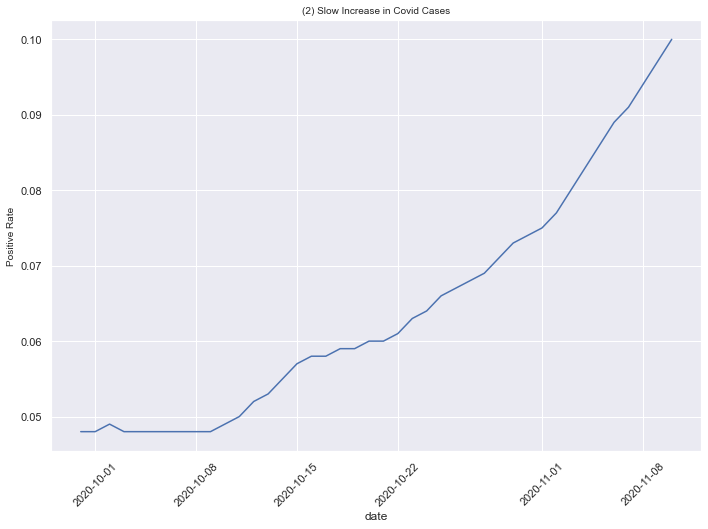

In [ ]:
peak_long_inc = pd.to_datetime('2020-09-30')
start_long_inc = pd.to_datetime('2020-11-10')
long_increase_df = df[(df.date >= peak_long_inc) & (df.date <= start_long_inc)]
plt.figure(figsize=(10,7))
sns.lineplot(data=long_increase_df, x='date', y='positive_rate')
plt.title('(2) Slow Increase in Covid Cases', fontsize=10)
plt.ylabel('Positive Rate', fontsize=10)
plt.tight_layout()
plt.xticks(rotation=45)

li_mean = long_increase_df.prediction.mean()
print(f'The average sentiment score during the long increase in cases: {round(li_mean,3)}')
print(f'percent change from the average: {percent_change(li_mean)}%')
average_sentiment.append(li_mean)
percent_change_avg.append(percent_change(li_mean))

# plt.savefig('figures/(2) Slow Increase in Covid Cases')

The average sentiment score during the long increase in cases: -0.05
percent change from the average: 72.6%


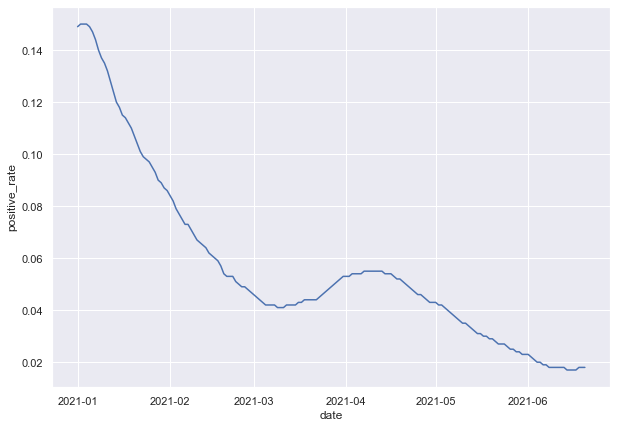

In [ ]:
delta_decrease_df = df[(df.date >= '2021-01-01') & (df.date <= '2021-06-20')]
plt.figure(figsize=(10,7))
sns.lineplot(data=delta_decrease_df, x='date', y='positive_rate')
li_mean = delta_decrease_df.prediction.mean()
print(f'The average sentiment score during the long increase in cases: {round(li_mean,3)}')
print(f'percent change from the average: {percent_change(li_mean)}%')

The average sentiment score during the sharp increase  in cases: -0.314
percent change from the average: -70.9%


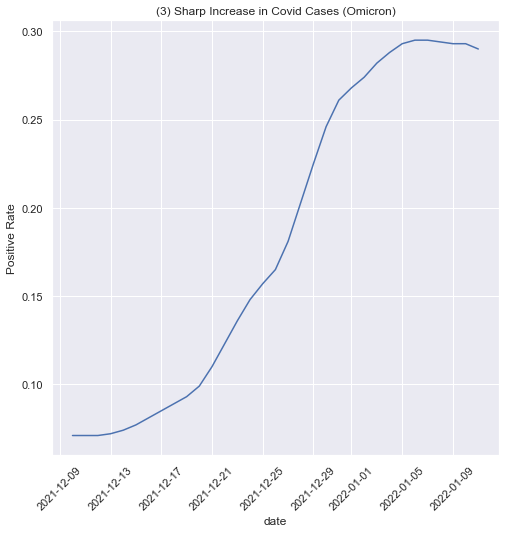

In [ ]:
peak_sharp_inc = pd.to_datetime('2022-01-11')
start_sharp_inc = pd.to_datetime('2021-12-10')

plt.figure(figsize=(8,8))
sharp_increase_df = df[(df.date <= peak_sharp_inc) & (df.date >= start_sharp_inc)]
sns.lineplot(data=sharp_increase_df, x='date', y='positive_rate')

plt.title('(3) Sharp Increase in Covid Cases (Omicron)')
plt.ylabel('Positive Rate')
plt.xticks(rotation=45)

si_avg = sharp_increase_df.prediction.mean()
print(f'The average sentiment score during the sharp increase  in cases: {round(si_avg,3)}')
print(f'percent change from the average: {percent_change(si_avg)}%')
average_sentiment.append(si_avg)
percent_change_avg.append(percent_change(si_avg))

# plt.savefig('figures/(3) Sharp Increase in Covid Cases (Omicron)')

In [ ]:
sharp_increase_df['date_ordinal'] = pd.to_datetime(sharp_increase_df['date']).apply(lambda date: date.toordinal())
long_increase_df['date_ordinal'] = pd.to_datetime(long_increase_df['date']).apply(lambda date: date.toordinal())

In [ ]:
plt.figure(figsize=(12,7))
sns.lineplot(data=long_decrease_df, x='date', y='avg_predict');
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Sentiment Score During Slow Decreasing Covid Cases')

ValueError: Could not interpret value `avg_predict` for parameter `y`

<Figure size 864x504 with 0 Axes>

The average sentiment score during the sharp decrease  in cases: -0.161
percent change from the average: 12.2%


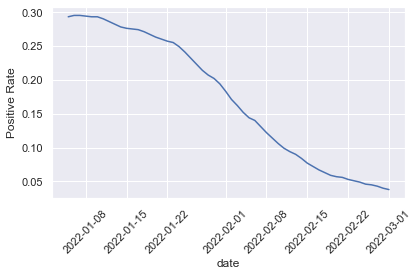

In [ ]:
peak_sharp_dec = pd.to_datetime('2022-01-05')
start_sharp_dec = pd.to_datetime('2022-03-01')

sharp_decrease_df = df[(df.date >= peak_sharp_dec)& (df.date <= start_sharp_dec)]
sns.lineplot(data=sharp_decrease_df, x='date', y='positive_rate')

plt.ylabel('Positive Rate')
plt.xticks(rotation=45)
plt.tight_layout()

sd_avg =sharp_decrease_df.prediction.mean()
print(f'The average sentiment score during the sharp decrease  in cases: {round(sd_avg,3)}')
print(f'percent change from the average: {percent_change(sd_avg)}%')
average_sentiment.append(sd_avg)
percent_change_avg.append(percent_change(sd_avg))

In [ ]:
# plt.figure(figsize=(14,10))
# sns.lineplot(data=df, x='date', y='positive_rate')

# plt.axvline(x=start_long_inc, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_long_inc, color='k', linestyle='--', linewidth=0.75)

# plt.axvline(x=start_sharp_dec, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_sharp_dec, color='k', linestyle='--', linewidth=0.75)

# plt.axvline(x=start_sharp_inc, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_sharp_inc, color='k', linestyle='--', linewidth=0.75)

# plt.axvline(x=start_slow_dec, color='k', linestyle='--', linewidth=0.75)
# plt.axvline(x=peak_slow_dec, color='k', linestyle='--', linewidth=0.75)

# plt.title('Four Timelines ')
# plt.ylabel('Covid Positive  Rate');

In [ ]:
long_decrease_df['date_ordinal'] = pd.to_datetime(long_decrease_df['date']).apply(lambda date: date.toordinal())
sharp_decrease_df['date_ordinal'] = pd.to_datetime(sharp_decrease_df['date']).apply(lambda date: date.toordinal())

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/176043633.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(new_labels)
/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/176043633.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(new_labels)


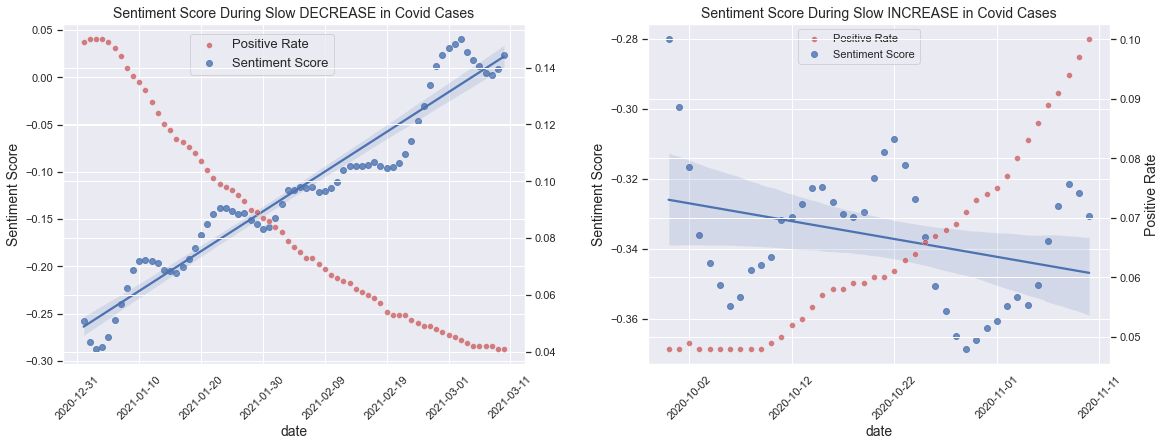

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

odd_styles = dict(color='r', alpha=0.7, label='Covid Positive Rate', legend=False)

ax1 = sns.regplot(data=long_decrease_df, x='date_ordinal', y='smoothed_prediction', ax=ax1, label='Sentiment Score')
ax1.set_ylabel('Sentiment Score', fontsize=14)
ax1.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax1.get_xticks()]
ax1.set_xticklabels(new_labels)
ax1.set_title('Sentiment Score During Slow DECREASE in Covid Cases', fontsize=14)

ax3 = ax1.twinx()
ax3 = sns.scatterplot(data=long_decrease_df, x='date_ordinal', y='positive_rate', ax=ax3, **odd_styles)
ax3.set_ylabel('')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.6, 0.99), fontsize=13)

ax2 = sns.regplot(data=long_increase_df, x='date_ordinal', y='smoothed_prediction', ax=ax2, label='Sentiment Score');
ax2.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax2.get_xticks()]
ax2.set_xticklabels(new_labels)
ax2.set_ylabel('Sentiment Score', fontsize=14)
ax2.set_title('Sentiment Score During Slow INCREASE in Covid Cases', fontsize=14)
ax4 = ax2.twinx()
ax4 = sns.scatterplot(data=long_increase_df, x='date_ordinal', y='positive_rate', ax=ax4, **odd_styles)
ax4.set_ylabel('Positive Rate', fontsize=14)

lines3, labels = ax2.get_legend_handles_labels()
lines4, labels2 = ax4.get_legend_handles_labels()
ax2.legend(lines4 + lines3, labels2 + labels, bbox_to_anchor=(0.6, 1))

for ax in f.axes:
    plt.sca(ax);
    plt.xticks(rotation=45)

plt.tight_layout(pad=3.0);
f.savefig('figures/slow increase and decrease in cases regplot.png', dpi=500);

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/673542748.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(new_labels)
/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_59389/673542748.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(new_labels)


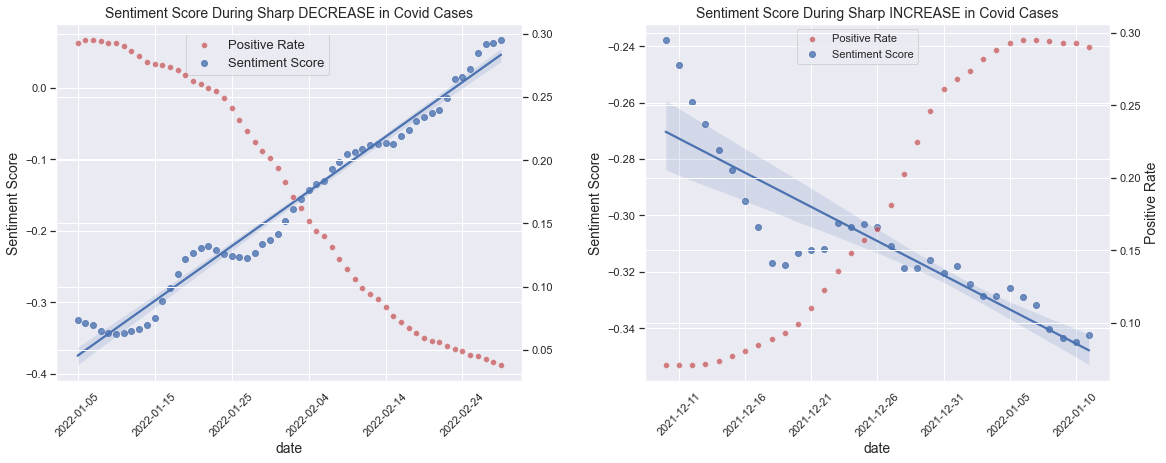

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))

ax1 = sns.regplot(data=sharp_decrease_df, x='date_ordinal', y='smoothed_prediction', ax=ax1, label='Sentiment Score')
ax1.set_ylabel('Sentiment Score', fontsize=14)
ax1.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax1.get_xticks()]
ax1.set_xticklabels(new_labels)

ax3 = ax1.twinx()
ax3 = sns.scatterplot(data=sharp_decrease_df, x='date_ordinal', y='positive_rate', ax=ax3, color='r', alpha=0.7, label='Positive Rate', legend=False)
ax3.set_ylabel('')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0.6, 0.99), fontsize=13)

ax2 = sns.regplot(data=sharp_increase_df, x='date_ordinal', y='smoothed_prediction', ax=ax2, label='Sentiment Score');
ax2.set_xlabel('date', fontsize=14)
new_labels = [date.fromordinal(int(item)) for item in ax2.get_xticks()]
ax2.set_xticklabels(new_labels)
ax2.set_ylabel('Sentiment Score', fontsize=14)
ax4 = ax2.twinx()
ax4 = sns.scatterplot(data=sharp_increase_df, x='date_ordinal', y='positive_rate', ax=ax4, color='r', alpha=0.7, label='Positive Rate', legend=False)
ax4.set_ylabel('Positive Rate', fontsize=14)

lines3, labels = ax2.get_legend_handles_labels()
lines4, labels2 = ax4.get_legend_handles_labels()
ax2.legend(lines4 + lines3, labels2 + labels, bbox_to_anchor=(0.6, 1))

for ax in f.axes:
    plt.sca(ax);
    plt.xticks(rotation=45);
plt.tight_layout(pad=3.0);
ax1.set_title('Sentiment Score During Sharp DECREASE in Covid Cases', fontsize=14)
ax2.set_title('Sentiment Score During Sharp INCREASE in Covid Cases', fontsize=14);
f.savefig('figures/sharp increase and decrease regplot.png', dpi=500);

In [ ]:
sentim_anal = pd.DataFrame({'Average Sentiment':average_sentiment, 'Percent Change': percent_change_avg})
sentim_anal = sentim_anal.round(2)
# sentim_anal['Percent Change'] = sentim_anal['Percent Change'].apply(lambda x: str(x)+'%')
sentim_anal['Percent Change'] = sentim_anal['Percent Change'].str.suffix('%')

sentim_anal.index = ['(1) Slow  Decrease', '(2) Sharp Decrease' , '(3) Slow  Increase', '(4) Sharp Increase']
sentim_anal.index.name = 'Change in Covid Cases'
slow_inc, sharp_inc, sharp_dec = sentim_anal.iloc[1].copy(), sentim_anal.iloc[2].copy(), sentim_anal.iloc[3].copy()
sentim_anal.iloc[1] = sharp_dec
sentim_anal.iloc[2] = slow_inc
sentim_anal.iloc[3] = sharp_inc
sentim_anal

NameError: name 'average_sentiment' is not defined

In [ ]:
sentim_anal.to_latex('latex_tables/percent_change_avg_sentim.tex')

/var/folders/7b/prbmv40d5wg4ymrn9dr3c76c0000gn/T/ipykernel_73144/2074057831.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sentim_anal.to_latex('latex_tables/percent_change_avg_sentim.tex')


**Long Decrease**

In [ ]:
ld_pearson_corr, ld_pearson_p_val, ld_spearman_corr, ld_spearman_p_val, ld_kendal_corr, ld_kendal_p_val = run_corr(dataframe=long_decrease_df, predictor_list=predictor_list)
ld_analysis_df = pd.DataFrame({'Pearson Correlation' : ld_pearson_corr,'Spearman Correlation' : ld_spearman_corr, 'Kendall Correlation' : ld_kendal_corr})
ld_p_val_df = pd.DataFrame({'Pearson p-value': ld_pearson_p_val, 'Spearman p-value': ld_spearman_p_val, 'Kendall p-value': ld_kendal_p_val})
ld_analysis_df.index = predictor_list
ld_p_val_df.index = predictor_list
ld_analysis_df

,Pearson Correlation,Spearman Correlation,Kendall Correlation
new_cases,-0.765,-0.813,-0.591
new_cases_smoothed,-0.834,-0.878,-0.676
new_deaths_smoothed,-0.703,-0.704,-0.498
weekly_hosp_admissions,-0.870,-0.901,-0.710
positive_rate,-0.895,-0.922,-0.760


In [ ]:
# ld_pearson_corr = []
# ld_pearson_p_val = []
# for predictor in predictor_list:
#     corr, p_val = calc_corr(dataframe=delta_decrease_df, predictor=predictor)
#     ld_pearson_corr.append(corr)
#     ld_pearson_p_val.append(p_val)

# ld_spearman_corr = []
# ld_spearman_p_val = []
# for predictor in predictor_list:
#     corr, p_val = calc_corr(dataframe=delta_decrease_df, predictor=predictor, spearman=True)
#     ld_spearman_corr.append(corr)
#     ld_spearman_p_val.append(p_val)

# ld_kendal_corr = []
# ld_kendal_p_val = []
# for predictor in predictor_list:
#     corr, p_val = calc_corr(dataframe=delta_decrease_df,predictor=predictor, kend=True)
#     ld_kendal_corr.append(corr)
#     ld_kendal_p_val.append(p_val)

# ld_pearson_corr, ld_pearson_p_val, ld_spearman_corr, ld_spearman_p_val, ld_kendal_corr, ld_kendal_p_val = run_corr(dataframe=delta_decrease_df, predictor_list=predictor_list)

# ld_analysis_df = pd.DataFrame({'Pearson Correlation' : ld_pearson_corr,'Spearman Correlation' : ld_spearman_corr, 'Kendall Correlation' : ld_kendal_corr})
# ld_p_val_df = pd.DataFrame({'Pearson p-value': ld_pearson_p_val, 'Spearman p-value': ld_spearman_p_val, 'Kendall p-value': ld_kendal_p_val})
# ld_analysis_df.index = predictor_list
# ld_p_val_df.index = predictor_list
# ld_analysis_df

# Testing Section

In [36]:
pre_df = pd.read_csv('csv/us_apr-feb2021.csv', index_col=[0])
pre_df['smooth_prediction'] = pre_df.prediction.rolling(4, center=True).mean()
post_df = pd.read_csv('csv/us-mar-apr2022.csv', index_col=[0])
post_df['smooth_prediction'] = post_df.prediction.rolling(4, center=True).mean()
df = pd.concat((pre_df,post_df),axis=0)
df.date = pd.to_datetime(df.date)
# new_df.set_index('date')


<AxesSubplot:>

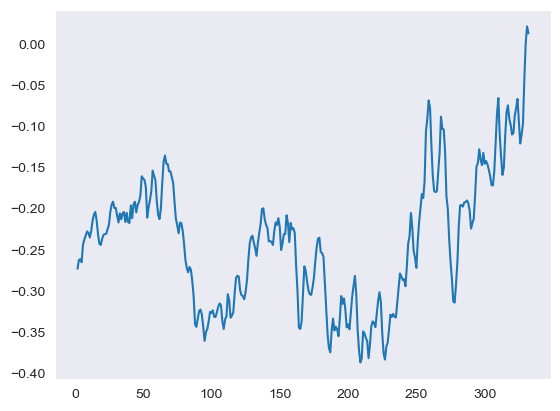

In [37]:
pre_df.smooth_prediction.plot()

Text(0.5, 0, 'Date')

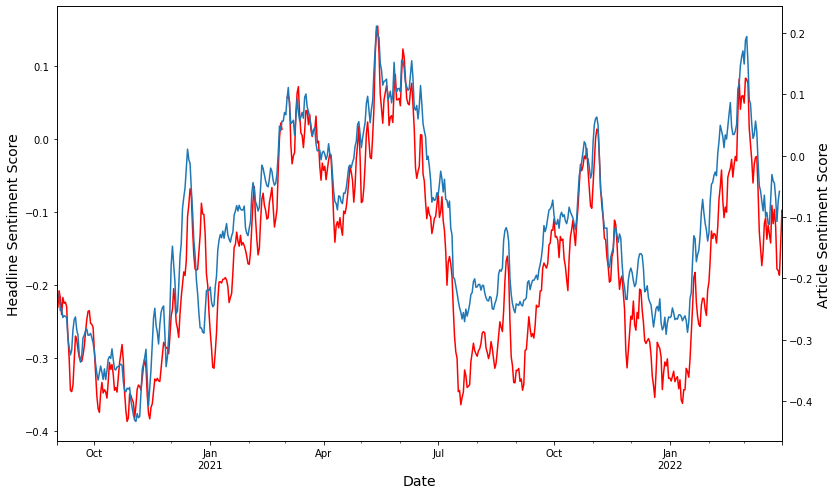

In [ ]:
ax = df.plot(x="date", y="smooth_prediction", legend=False, color ='r',figsize=(13,8), label='new')
ax2 = ax.twinx()
df.plot(x="date", y="avg_predict", ax=ax2, legend=False, label='old')

# plt.title('Comparing Average Daily Article Sentiment Against New Covid Cases')
ax.set_ylabel('Headline Sentiment Score', fontsize=14)
ax2.set_ylabel('Article Sentiment Score', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

In [44]:
t_df.groupby(level=0)['prediction'].mean().std()

0.12152367192662977

In [52]:
t_df.groupby(level=0, as_index=True)['prediction'].mean()

date
2020-03-01   -0.271667
2020-03-02   -0.276344
2020-03-03   -0.115248
2020-03-04   -0.200917
2020-03-05   -0.179094
                ...   
2022-04-26   -0.347930
2022-04-27   -0.215190
2022-04-28   -0.112000
2022-04-29   -0.099718
2022-04-30   -0.123810
Name: prediction, Length: 791, dtype: float64

In [58]:
cc = t_df.groupby(level=0, as_index=True)['prediction'].mean().reset_index()
cc['smoothed_prediction'] = cc['prediction'].rolling(window=5, center=True, win_type='gaussian').mean(std=2)

In [61]:
cc

,date,prediction,smoothed_prediction
0,2020-03-01,-0.271667,NaN
1,2020-03-02,-0.276344,NaN
2,2020-03-03,-0.115248,-0.203574
3,2020-03-04,-0.200917,-0.191085
4,2020-03-05,-0.179094,-0.188439
...,...,...,...
786,2022-04-26,-0.347930,-0.252222
787,2022-04-27,-0.215190,-0.198055
788,2022-04-28,-0.112000,-0.169940
789,2022-04-29,-0.099718,NaN


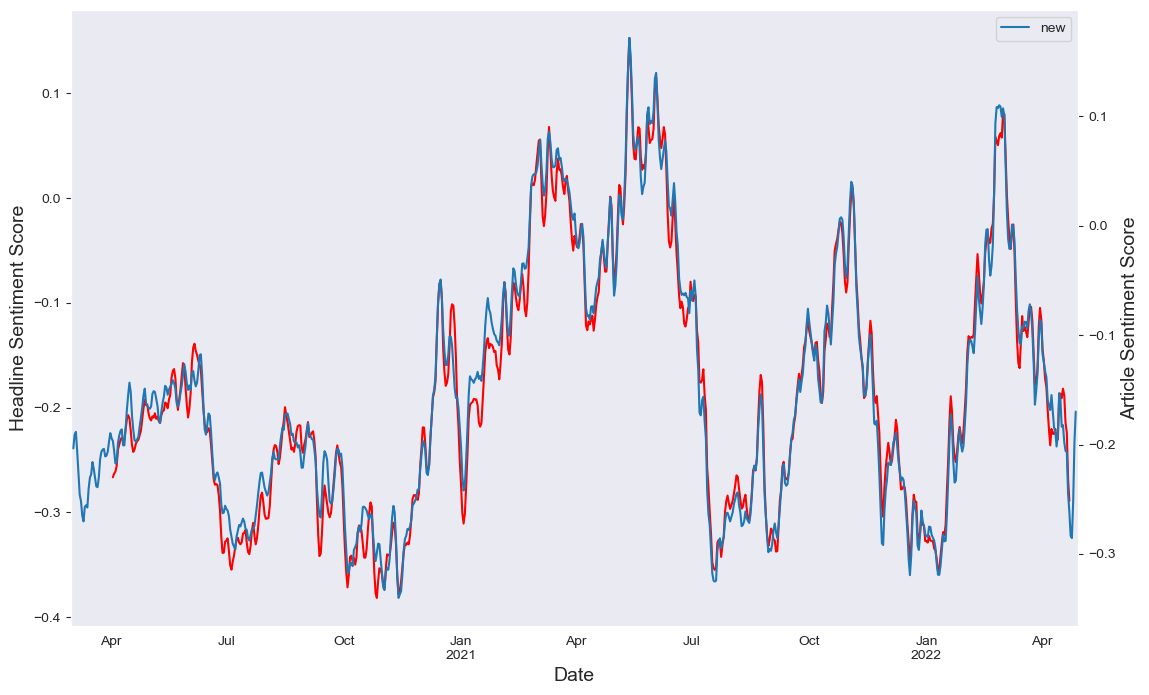

In [62]:
ax = df.plot(x="date", y="smoothed_prediction", legend=False, color ='r',figsize=(13,8), label='old')
ax2 = ax.twinx()
cc.plot(x='date', y="smoothed_prediction", ax=ax2, legend=False, label='new')


# plt.title('Comparing Average Daily Article Sentiment Against New Covid Cases')
ax.set_ylabel('Headline Sentiment Score', fontsize=14)
ax2.set_ylabel('Article Sentiment Score', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.legend()